In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
CHANNELS=3

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/train',
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
   '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/val',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))
test_generator = validation_datagen.flow_from_directory(
   '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/test',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))

Found 5633 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 1597 images belonging to 2 classes.


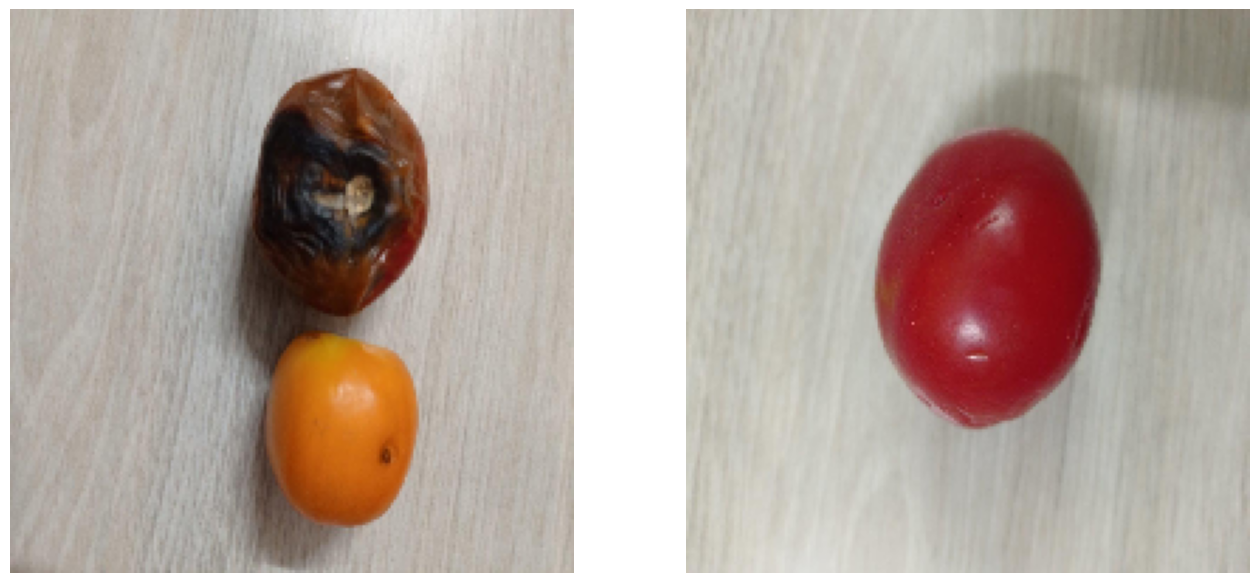

In [7]:
# Define the target size for resizing the images
target_size = (200, 200)  # Specify the desired size, for example, (width, height)

# Define the paths to your dataset for each class
class1_path = '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/test/Defect'
class2_path = '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/test/Fresh'

# Function to load and visualize a sample image
def visualize_sample(class_path, ax):
    # Get a list of all files in the class path
    files = tf.io.gfile.glob(class_path + '/*')

    # Choose a random file
    sample_file = np.random.choice(files)

    # Load and resize the image
    img = image.load_img(sample_file, target_size=target_size)

    # Display the image
    ax.imshow(img)
    ax.axis('off')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

# Visualize a sample from class 1
visualize_sample(class1_path, axs[0])

# Visualize a sample from class 2
visualize_sample(class2_path, axs[1])

# Show the plot
plt.show()

In [8]:
x,y=test_generator.next()
x.shape

(32, 224, 224, 3)

In [9]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='sigmoid')(x)
model = Model(conv_base.input, predictions)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=test_generator,
    epochs=10
)

Epoch 1/10
177/177 [==============================] - 2598s 15s/step - loss: 0.1220 - accuracy: 0.9535 - val_loss: 0.1266 - val_accuracy: 0.9499
Epoch 2/10
177/177 [==============================] - 366s 2s/step - loss: 0.0681 - accuracy: 0.9734 - val_loss: 0.0905 - val_accuracy: 0.9674
Epoch 3/10
177/177 [==============================] - 344s 2s/step - loss: 0.0436 - accuracy: 0.9828 - val_loss: 0.0703 - val_accuracy: 0.9693
Epoch 4/10
177/177 [==============================] - 380s 2s/step - loss: 0.0379 - accuracy: 0.9838 - val_loss: 0.0658 - val_accuracy: 0.9756
Epoch 5/10
177/177 [==============================] - 365s 2s/step - loss: 0.0293 - accuracy: 0.9888 - val_loss: 0.0334 - val_accuracy: 0.9837
Epoch 6/10
177/177 [==============================] - 382s 2s/step - loss: 0.0367 - accuracy: 0.9867 - val_loss: 0.1359 - val_accuracy: 0.9555
Epoch 7/10
177/177 [==============================] - 355s 2s/step - loss: 0.0317 - accuracy: 0.9869 - val_loss: 0.0788 - val_accuracy: 0.97

In [14]:
loss, accuracy = model.evaluate(test_generator )

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

50/50 [==============================] - 14s 272ms/step - loss: 0.0627 - accuracy: 0.9793
Accuracy: 0.9793362617492676
Loss: 0.0627342239022255


In [15]:
test_generator.class_indices

{'Defect': 0, 'Fresh': 1}

In [16]:
import numpy as np
from sklearn import metrics

predictions = model.predict_generator(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels = ['Defect','Fresh']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

<ipython-input-16-9ee6b6c6f934>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


              precision    recall  f1-score   support

      Defect       1.00      0.96      0.98       727
       Fresh       0.97      1.00      0.98       870

    accuracy                           0.98      1597
   macro avg       0.98      0.98      0.98      1597
weighted avg       0.98      0.98      0.98      1597



<Axes: >

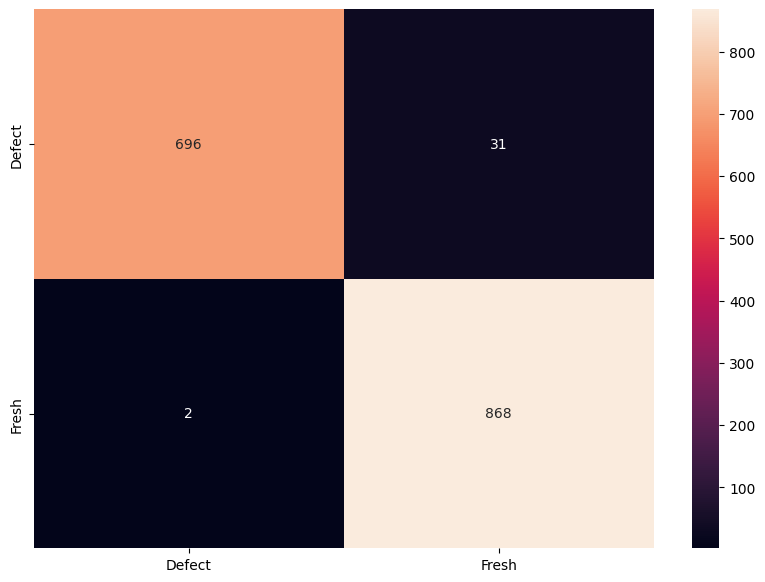

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Defect','Fresh']],
                  columns = [i for i in ['Defect','Fresh']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

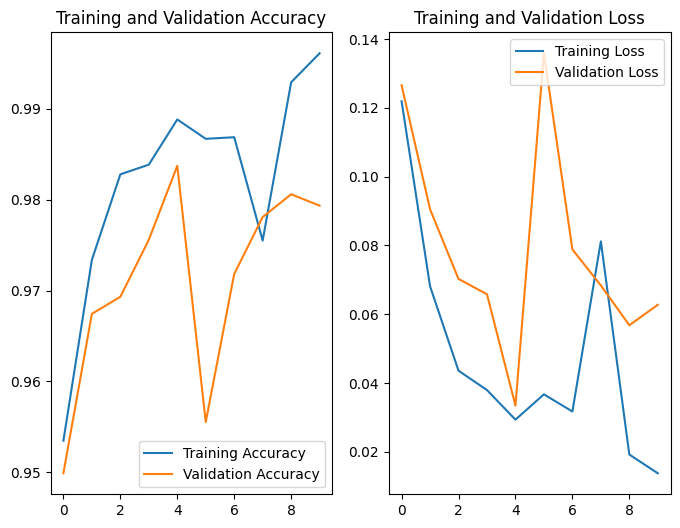

In [21]:
EPOCHS=10
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

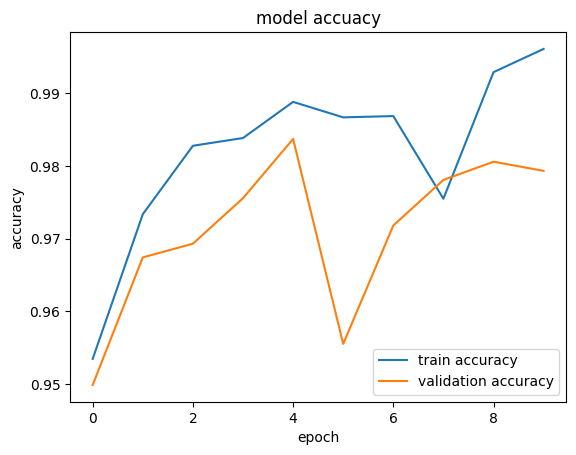

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

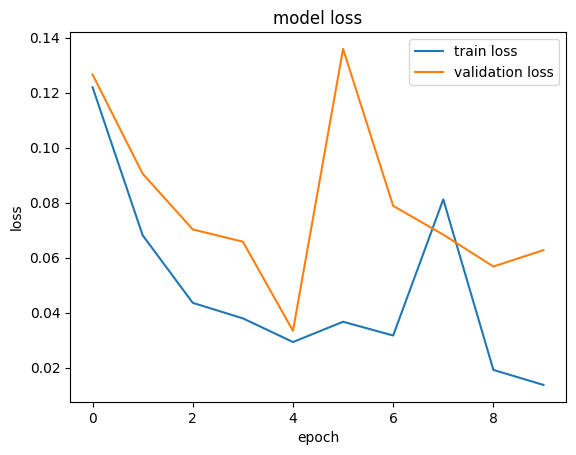

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()